【データ】
1. 2nd_task_train_dataset.csv
    - 分子とその特徴量および目的物性
    - "SMILES": 分子ID
    - "y_std", "y_mm": 目的物性（標準化, MinMax正規化）
    - その他: 分子の特徴量
2. 2nd_task_population.csv
    - 探索対象の分子のIDおよび特徴量

【課題】
- 評価済の分子データを用いて、探索対象分子の中から目的物性を最大化するような候補分子を選択せよ。

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor

import math
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
data = pd.read_csv('2nd_task_train_dataset.csv')
data

,SMILES,y_std,y_mm,0_KT3NTg,0_22G2dA,0__Xf0XQ,0_UDsTnQ,0__9pFdA,0_XxojpQ,0_0-gpnQ,...,6_0_7Ugw,6_UG6uRA,6_PJ996g,6_nkOG3w,6_Hs1t6g,6_6LbVvw,6_sHINEg,6_GwgXwg,6_Y1zB9A,6_zZVrug
0,CCCCCCCCCCCc1ccccc1,-0.707086,0.460948,12.020815,9.687893,0,0,21.685508,2.158449,4.316897,...,-0.000050,-0.000004,45,6,6,48.590204,-0.8041,0.646577,62.5656,0
1,O=C(O)CCCCc1ccccc1,0.034151,0.620999,9.411168,8.254273,1,0,16.194221,2.160195,4.320390,...,-0.000679,0.003472,27,6,6,30.299102,0.9556,0.913171,48.0542,1
2,Cc1ccc(N)cc1C,-0.042938,0.604353,6.651690,6.355891,0,0,10.792280,2.245827,4.491654,...,0.004361,0.002059,20,6,6,22.514723,2.1832,4.766362,40.7657,0
3,O=S(=O)(c1ccccc1)c1ccccc1,0.876196,0.802817,11.508327,10.119658,0,0,19.529886,2.403842,4.807684,...,-0.015535,-0.000424,25,12,12,32.291930,3.0970,9.591409,57.0716,0
4,CC12NC(Cc3ccccc31)c1ccccc12,0.167574,0.649808,14.056515,11.377307,0,1,23.230602,2.614762,5.066769,...,0.010448,0.001852,32,12,12,39.261895,2.7830,7.745089,69.8712,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...,1.226060,0.878361,20.617352,16.677136,0,0,31.703671,2.489345,4.867957,...,0.049064,0.062420,40,17,17,48.730102,4.6357,21.489714,90.6342,0
996,CC(C)CCCC(C)CCCC(C)CCCCC(C)CCCC(C)CCCC(C)C,-1.098459,0.376440,21.381215,16.722649,0,0,34.850400,2.113920,4.227840,...,0.000000,0.000000,92,0,0,94.141166,2.5074,6.287055,124.6644,0
997,CC(=O)F,-1.644010,0.258643,2.449490,2.449490,0,0,3.464102,1.732051,3.464102,...,0.000000,0.000000,7,0,0,6.879379,0.0852,0.007259,11.8672,0
998,CCCCCCCCCCCC(=O)OC,-0.586116,0.487068,10.008885,8.957861,0,0,18.169374,2.017464,4.034927,...,-0.036986,0.001660,41,0,0,41.820618,-2.4947,6.223528,48.6407,0


In [3]:
population = pd.read_csv('2nd_task_population.csv')
population

,SMILES,0_KT3NTg,0_22G2dA,0__Xf0XQ,0_UDsTnQ,0__9pFdA,0_XxojpQ,0_0-gpnQ,0_1qSHdA,0_lbgewQ,...,6_0_7Ugw,6_UG6uRA,6_PJ996g,6_nkOG3w,6_Hs1t6g,6_6LbVvw,6_sHINEg,6_GwgXwg,6_Y1zB9A,6_zZVrug
0,O=C1c2ccccc2-c2ccc3c4ccc5c6c(ccc(c7ccc1c2c73)c...,30.522676,18.841674,0,0,50.860315,2.677716,5.355432,50.860315,1.412787,...,-0.006181,-0.000275,52,36,32,72.112688,7.0388,49.544705,142.4802,0
1,O=C1c2c(Br)c(Br)c(Br)c(Br)c2C(=O)N1CCN1C(=O)c2...,25.252613,21.507876,0,0,40.649970,2.584912,5.023844,40.649970,1.270312,...,-0.397405,-0.270302,36,12,12,64.155172,8.5870,73.736569,146.8356,0
2,c1cc2ccc3ccc4ccc5ccc6ccc1c1c2c3c4c5c61,20.727922,13.352493,0,0,34.571837,2.675131,5.350262,34.571837,1.440493,...,0.000000,0.000000,36,30,24,50.241516,5.4504,29.706860,98.7012,0
3,O=C1c2cccc([N+](=O)[O-])c2C(=O)c2cccc([N+](=O)...,17.222500,14.487698,0,0,28.077869,2.555457,5.110914,28.077869,1.276267,...,-0.035007,-0.309848,28,12,12,35.652758,3.9908,15.926485,65.2450,0
4,O=C1c2ccccc2-c2ccc3c4c(ccc1c24)-c1ccccc1C3=O,21.613368,15.083602,0,0,36.261617,2.632598,5.265197,36.261617,1.394678,...,-0.003345,0.014383,38,23,22,51.845516,4.9236,24.241837,101.8156,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8533,FC(F)(F)F,3.464102,3.464102,0,0,4.000000,2.000000,4.000000,4.000000,0.800000,...,0.000000,0.000000,5,0,0,3.988000,2.4374,5.940919,8.3090,0
8534,C=CC,1.414214,1.414214,0,0,2.828427,1.414214,2.828427,2.828427,0.942809,...,0.000000,0.000000,9,0,0,9.280758,1.1470,1.315609,15.8797,0
8535,C=CCC,2.121320,2.340100,0,0,4.472136,1.618034,3.236068,4.472136,1.118034,...,-0.000020,0.000000,12,0,0,12.374344,0.4708,0.221653,18.9575,0
8536,CCC,1.414214,1.414214,0,0,2.828427,1.414214,2.828427,2.828427,0.942809,...,0.000000,0.000000,11,0,0,10.614344,-0.1854,0.034373,14.7090,0


# 1. 目的物性の確認

In [4]:
y = data.iloc[:, 1:3]
y1 = y.iloc[:, 0]
y2 = y.iloc[:, 1]

Text(0, 0.5, 'y_mm')

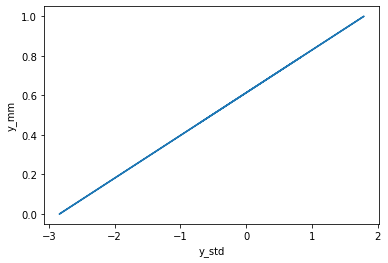

In [5]:
plt.plot(y1, y2)
plt.xlabel('y_std')
plt.ylabel('y_mm')

In [6]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

y1 = np.array(y1).reshape(-1, 1)
y2 = np.array(y2).reshape(-1, 1)
reg.fit(y1, y2)

LinearRegression()

In [7]:
print(reg.coef_)
print(reg.intercept_)
print(reg.score(y1, y2))

[[0.21592445]]
[0.61362469]
1.0


## 考察
- y_stdとy_mmとの間、＋の線形関係が分かったため、片方のみ最大化する問題に変換できる
- 解析方向：train_datasetから回帰モデルを構築　→　populationからy_stdを予測し、候補分子を選択

# 2. 前処理
## 2.1. 欠損データの処理
- train_datasetとpopulationをくっつけて、欠損値を含む列を除く

In [8]:
data_ = data.iloc[:, 3:]
population_ = population.iloc[:, 1:]

In [9]:
temp = pd.concat([data_, population_])
temp = temp.dropna(1)
temp

,0_KT3NTg,0_22G2dA,0__Xf0XQ,0_UDsTnQ,0__9pFdA,0_XxojpQ,0_0-gpnQ,0_1qSHdA,0_lbgewQ,0_fbPyPw,...,6_7kWBVQ,6_WqeyvQ,6_PJ996g,6_nkOG3w,6_Hs1t6g,6_6LbVvw,6_sHINEg,6_GwgXwg,6_Y1zB9A,6_zZVrug
0,12.020815,9.687893,0,0,21.685508,2.158449,4.316897,21.685508,1.275618,3.688767,...,16.000000,13.000000,45,6,6,48.590204,-0.8041,0.646577,62.5656,0
1,9.411168,8.254273,1,0,16.194221,2.160195,4.320390,16.194221,1.245709,3.436571,...,12.664184,9.664184,27,6,6,30.299102,0.9556,0.913171,48.0542,1
2,6.651690,6.355891,0,0,10.792280,2.245827,4.491654,10.792280,1.199142,3.099448,...,10.332364,4.332364,20,6,6,22.514723,2.1832,4.766362,40.7657,0
3,11.508327,10.119658,0,0,19.529886,2.403842,4.807684,19.529886,1.301992,3.633710,...,31.335877,23.996306,25,12,12,32.291930,3.0970,9.591409,57.0716,0
4,14.056515,11.377307,0,1,23.230602,2.614762,5.066769,23.230602,1.366506,3.833883,...,33.664728,26.664728,32,12,12,39.261895,2.7830,7.745089,69.8712,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8533,3.464102,3.464102,0,0,4.000000,2.000000,4.000000,4.000000,0.800000,2.444466,...,0.000000,0.000000,5,0,0,3.988000,2.4374,5.940919,8.3090,0
8534,1.414214,1.414214,0,0,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,...,0.000000,0.000000,9,0,0,9.280758,1.1470,1.315609,15.8797,0
8535,2.121320,2.340100,0,0,4.472136,1.618034,3.236068,4.472136,1.118034,2.155909,...,1.000000,0.000000,12,0,0,12.374344,0.4708,0.221653,18.9575,0
8536,1.414214,1.414214,0,0,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,...,0.000000,0.000000,11,0,0,10.614344,-0.1854,0.034373,14.7090,0


## 2.2. Train, Testデータ分け
- train_datasetを800、200個に分ける

In [10]:
train_index = data.index[:800]
test_index = data.index[800:]

train_X = temp.iloc[train_index]
train_y = data.iloc[train_index, 1]

test_X = temp.iloc[test_index]
test_y = data.iloc[test_index, 1]

## 2.3. Scaling

In [11]:
X_scaler = StandardScaler()
X_scaler.fit(train_X)

y_scaler = StandardScaler()
y_scaler.fit(pd.DataFrame(train_y))

StandardScaler()

In [12]:
train_X_scaled = X_scaler.transform(train_X)
test_X_scaled = X_scaler.transform(test_X)

train_y_scaled = y_scaler.transform(pd.DataFrame(train_y))
test_y_scaled = y_scaler.transform(pd.DataFrame(test_y))

# 3. 回帰モデル

In [13]:
regressor = RandomForestRegressor()
regressor.fit(train_X_scaled, train_y_scaled)

pred_y_scaled = regressor.predict(test_X_scaled)
pred_y = y_scaler.inverse_transform(pred_y_scaled)

print("R2   : ", r2_score(test_y, pred_y))
print("RMSE : ", math.sqrt(mean_squared_error(test_y, pred_y)))

<ipython-input-13-4bdc602d12d1>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(train_X_scaled, train_y_scaled)


R2   :  0.7544394547283019
RMSE :  0.5277636143266912


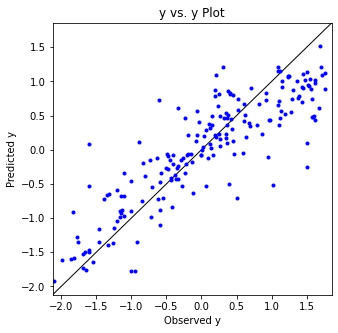

In [14]:
from YYPlot import YYPlot
yy_plot = YYPlot(test_y, pred_y)
yy_plot.draw_yyplot()

# 4. 候補分子の探索
- y_stdの予測値の高い20個を選択

In [15]:
popul_X = temp.iloc[1000:]
popul_X_scaled = X_scaler.transform(popul_X)

pred_popul_y_scaled = regressor.predict(popul_X_scaled)
pred_popul_y = y_scaler.inverse_transform(pred_popul_y_scaled)

pred_popul_y

array([ 0.82670148,  0.87562116,  0.82563806, ..., -2.0494626 ,
       -2.17977011, -1.74887829])

In [16]:
'np_arrayの中から、値の高いnum個を選ぶ'
def MoleculeSelect(np_array, num):
    index = np.argsort(np_array)[::-1][:num]
    molecule = population.iloc[index, 0]
    return molecule

In [17]:
MoleculeSelect(pred_popul_y, 20)

865     CC1CCC2(OC1)OC1CC3C4CC=C5CC(O)CCC5(C)C4CCC3(C)...
888                 CC1CC(=O)CC2CCC3C4CCC(O)C4(C)CCC3C12C
972                      Cc1cc2ncn(C3OC(CO)C(O)C3O)c2cc1C
884                                 COc1cc2ccc(=O)oc2cc1O
994     CC1(C)CCC2(C)CCC3(C)C(=CCC4C5(C)CCC(O)C(C)(C)C...
880                   COc1cc(S(C)=O)ccc1-c1nc2ncccc2[nH]1
921     O=C(CCCN1CCC(n2c(=S)[nH]c3ccccc32)CC1)c1ccc(F)cc1
223     CC1CCC2(OC1)OC1CC3C4CCC5CC(O)CCC5(C)C4CC(=O)C3...
996     CC1CCC2(OC1)OC1CC3C4CCC5CC(O)CCC5(C)C4CCC3(C)C...
1046                         O=C(O)c1cc(Cl)c(Cl)c(Cl)c1Cl
1957                CC12CCC(=O)C=C1CCC1C2CCC2(C)C(O)CCC12
2058              CC1CC2(C)C(CCC3C4CCC(O)C4(C)CCC32)CC1=O
780     CC1CCC2(NC1)OC1CC3C4CCC5CC(O)CCC5(C)C4CCC3(C)C...
457                 CC12CC(O)C3C(CCC4CC(O)CCC43C)C1CCC2=O
1101              CC(=O)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C
2210          CC1CC2=CC(=O)CCC2(C)C2CCC3(C)C(CCC3(C)O)C12
1086                CC12CCC(=O)CC1CCC1C2CCC2(C)C1CCC2(C)O
1927       CC(

# 5. 結果・考察
- y_std（あるいはy_mm）というラベルが付いてあるため、教師あり学習として取り扱い。
- そのうち、回帰問題としてアプローチした。
- よって、1000個のtrain_datasetから精度の高い回帰モデルを構築する問題になる。
- 回帰モデルではRandomForestを用いたが、回帰手法の選択・パラメータ調整等、予測精度の向上のための工夫が必要。